In [1]:
%load_ext autoreload
%autoreload 2
%run ~/FKMC/notebooks/notebook_preamble.py
%matplotlib inline
np.seterr(under = 'ignore')

Imported pathlib::Path, os, munch::Munch, pickle, logging, itertools::count, matplotlib::colors
Names are pyplot = plt, matplotlib = mpl, numpy = np


{'divide': 'warn', 'over': 'warn', 'under': 'warn', 'invalid': 'warn'}

In [2]:
from munch import munchify
from FKMC.general import smooth, spread
from scipy.stats import sem

#this data has was preprocessed and saved in munich/Figures/Data_preparation_for_linear_T_plots.ipynb
#gatherered using get_data_funcmap so IPR is normalised by DOS
with open('/workspace/tch14/pickled_data/High_Temp_IPR_DOS_and_errors_2.pickle', 'rb') as file: 
    o = oHighT = munchify(pickle.load(file))
    
print(f"Keys available in long range data: {o.keys()}")

print("Hamiltionian params for the Long Range data:")
o.parameters.beta = "Variable"
print(", ".join(f"{k} = {v}" for k,v in o.parameters.items()))
print('\n')

print("Simulation params for the Long Range data:")
print(o.MCMC_params)

print('\nShape hint for o.IPR')
print(o.hints.DOS)
print(o.DOS.shape)
    
o.energy_histogram_bins = o.E_bins

#pluck out particular Ns and starting states
Nmask = (o.Ns > 8)
o.Ns = o.Ns[Nmask]
print(o.Ns, Nmask)
for name in ['DOS', 'dDOS', 'IPR', 'dIPR']:
    o[name] = o[name][Nmask]
    #o[name] = o[name][:, :, [0,1,2]] #get particular starting states

axis = (1,2) #mean out the repeat and starting states axes
print(f'Taking mean over axes {axis} which are {np.array(o.hints.DOS)[axis,]}')

#use the indepedant repeats to estimate the errors
#o.DOS, o.dDOS = o.DOS.mean(axis = axis), sem(o.DOS.mean(axis = 3), axis = 2)
#o.IPR, o.dIPR = o.IPR.mean(axis = axis), sem(o.IPR.mean(axis = 3), axis = 2)

#use binning over the mcmc steps to estimate the errors
o.DOS, o.dDOS = o.DOS.mean(axis = axis), o.dDOS.mean(axis = axis)
o.IPR, o.dIPR = o.IPR.mean(axis = axis), o.dIPR.mean(axis = axis)

print('\nShape of o.DOS after mean')
print("Should be ('Ns', 'Ts', 'energy index')")
print(o.DOS.shape)

#('Ns', 'Ts', 'energy index')

#smooth them
for i, N in zip(count(), o.Ns):
    o.DOS[i] = smooth(o.DOS[i], scale = 32 / N) / N
    o.IPR[i] = smooth(o.IPR[i], scale = 32 / N)

    o.dDOS[i] = smooth(o.dDOS[i], scale = 32 / N) / N
    o.dIPR[i] = smooth(o.dIPR[i], scale = 32 / N)
    
print('Loaded data for Long Range IPR and DOS as a function of T')

Keys available in long range data: dict_keys(['E_bins', 'IPR', 'DOS', 'dIPR', 'dDOS', 'Mf_moments', 'sigma_Mf_moments', 'Ns', 'Ts', 'parameters', 'MCMC_params', 'desc', 'structure_names', 'structure_dims', 'hints', 'T'])
Hamiltionian params for the Long Range data:
t = 1, alpha = 1.25, mu = 0, beta = Variable, J = 5, U = 1, normalise = True, J_matrix = ...


Simulation params for the Long Range data:
Munch({'state': '...', 'N_steps': 10000, 'N_burn_in': 1000, 'thin': 100, 'logger': <FKMC.montecarlo.Eigenspectrum_IPR_all object at 0x7f5902635828>, 'proposal': <function p_multi_site_uniform_reflect at 0x7f5902639f28>, 'accept_function': <function perturbation_accept at 0x7f590263a2f0>, 'warnings': True})

Shape hint for o.IPR
('Ns', 'repeats', 'initial_state', 'Ts', 'energy index')
(5, 1, 3, 8, 2000)
[ 30  60  90 120 150] [ True  True  True  True  True]
Taking mean over axes (1, 2) which are ['repeats' 'initial_state']

Shape of o.DOS after mean
Should be ('Ns', 'Ts', 'energy index')
(5,

In [3]:
from FKMC.general import interaction_matrix, solve_H_vectorised, shapes
from FKMC.general import index_histogram_array, sort_IPRs, normalise_IPR, smooth, get_nearby_index, spread

def solve(states, params, energy_histogram_bins, scale = 1):
    params.J_matrix = interaction_matrix(**params)

    #NB the states argument should have only 1s and 0s
    #Fc is infinite at infinite temperature
    Ff, Fc, eigenvals, eigenvecs = solve_H_vectorised(states, **params)

    #calculate the IPR measure
    IPR_raw_values = ((eigenvecs * np.conj(eigenvecs))**2).sum(axis = -2)

    #take lists of IPR and eigenvalues and bin them into histograms
    DOS, _, sorting_indices = index_histogram_array(energy_histogram_bins, eigenvals)
    IPR = sort_IPRs(sorting_indices, IPR_raw_values, energy_histogram_bins)

    DOS, dDOS = DOS.mean(axis = 0), scipy.stats.sem(DOS, axis = 0)
    IPR, dIPR = IPR.mean(axis = 0), scipy.stats.sem(IPR, axis = 0)

    #divide IPR by DOS without incurring divide by errors where DOS = 0, set IPR = 0 there too
    DOS, IPR = normalise_IPR(DOS, IPR)
    _, dIPR = normalise_IPR(DOS, dIPR)

    #smooth out the spikey IPR values
    DOS = smooth(DOS, scale = scale, axis = -1) / N
    IPR = smooth(IPR, scale = scale, axis = -1)
    
    dDOS = smooth(dDOS, scale = scale, axis = -1) / N
    dIPR = smooth(dIPR, scale = scale, axis = -1)
    
    return DOS, IPR, dDOS, dIPR

print(f'Computing the infT limit for Ns = {oHighT.Ns}')
oinfT = Munch()
o = oinfT
o.N_eigenstates = int(1e5) # do states / N disorder realisations
o.Ns = oHighT.Ns# system sizes
o.Ts = np.array([np.infty,])

o.t = 1
o.U = 1
o.J = 5
o.spread_IPR = False

o.energy_histogram_bins = oHighT.E_bins
shape = (4, len(o.Ns), 1, len(o.energy_histogram_bins)-1)
o.DOS, o.IPR, o.dDOS, o.dIPR = np.nan * np.zeros(shape = shape)

for i,N in zip(count(), o.Ns):
    M = o.N_eigenstates // N + 1 # Number of Disorder_realisations
    states = np.random.choice([1,0], size = (M,N)) #take 50-50 uncorrelated coin flips to simulate infinite temp limit.
    o.parameters = Munch(mu=0.0, beta = np.nan, U = o.U, t = o.t, N = N, alpha = 1.25, J = o.J)
    o.DOS[i], o.IPR[i], o.dDOS[i], o.dIPR[i] = solve(states, o.parameters, scale = 0.5, energy_histogram_bins = o.energy_histogram_bins)
    
o.hints = Munch()
for name in ['DOS', 'IPR', 'dIPR', 'dDOS']: o.hints[name] = ('Ns', 'Ts', 'energy')

Computing the infT limit for Ns = [ 30  60  90 120 150]


In [4]:
#put them both together
oBoth = Munch()
oBoth.Ts = np.concatenate([[np.inf], oHighT.Ts])
for name in ['parameters', 'Ns', 'energy_histogram_bins']:
    oBoth[name] = oHighT[name]
    
for name in ['DOS', 'IPR', 'dIPR', 'dDOS']: 
    shapes(oinfT[name], oHighT[name])
    oBoth[name] = np.concatenate([oinfT[name], oHighT[name]], axis = 1)

(5, 1, 2000), (5, 8, 2000)
(5, 1, 2000), (5, 8, 2000)
(5, 1, 2000), (5, 8, 2000)
(5, 1, 2000), (5, 8, 2000)


t=1 alpha=1.25 mu=0 beta=Variable J=5 U=1 normalise=True


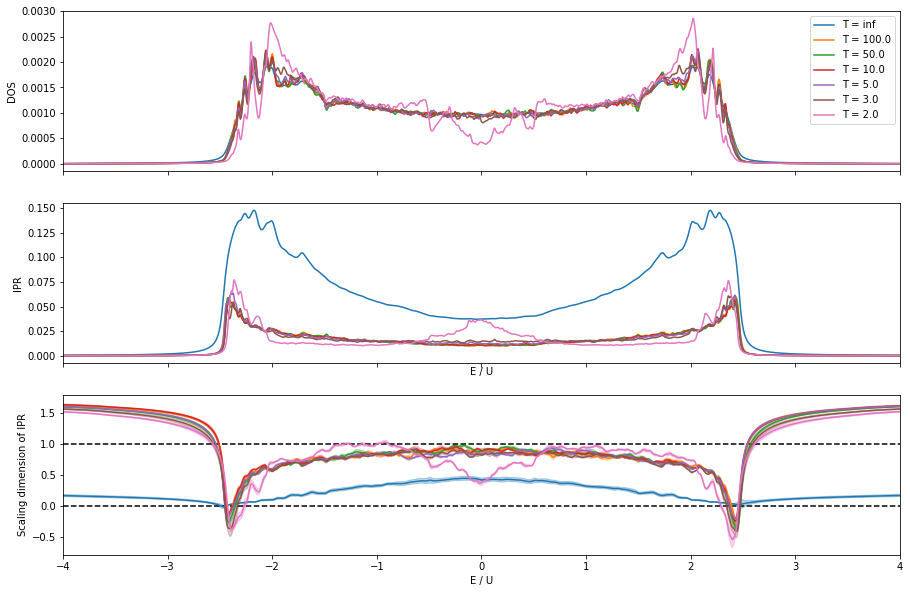

In [5]:
def scaling_dimension(Ns, IPR, dIPR, use_true_errors = True):
    Y = np.log(IPR)
    dY = np.max(dIPR / IPR, axis = -1) #take the maximum error across the energy spectrum because we can't do it individually
    X = np.log(Ns)

    if use_true_errors:
        (m, c), cov = np.polyfit(X, Y, deg = 1, cov=True, w = 1 / dY)
    else:
        (m, c), cov = np.polyfit(X, Y, deg = 1, cov=True)
    dm, dc = np.sqrt(np.einsum('iik -> ik', cov))
    
    return m, c, dm, dc


def plot_Ts(o, N_i = -1, spread_IPR = True, Tselect = None):
    print(" ".join(f'{k}={v}' for k,v in o.parameters.items() if k != 'J_matrix'))
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    f, axes = plt.subplots(3,1, figsize = (15,10), sharex = 'col')
    
    T_is = np.arange(len(o.Ts))
    Ts = o.Ts[Tselect] if Tselect else o.Ts
    T_is = T_is[Tselect] if Tselect else T_is
    
    for T_i, T in zip(T_is, Ts):
        try:
            m, c, dm, dc = scaling_dimension(o.Ns, o.IPR[:, T_i], o.dIPR[:, T_i], use_true_errors = True)
            scaling_fit = True
        except np.linalg.LinAlgError:
            scaling_fit = False

        i = N_i
        N = o.Ns[N_i]
        axes[0].plot(o.energy_histogram_bins[1:] / o.parameters.U, o.DOS[i, T_i], label = f'T = {T}', color = colors[T_i])
        if spread_IPR:
            spread(axes[1], o.energy_histogram_bins[1:] / o.parameters.U, o.IPR[i, T_i], o.dIPR[i, T_i], color = colors[T_i])
        else:    
            axes[1].plot(o.energy_histogram_bins[1:] / o.parameters.U, o.IPR[i, T_i], color = colors[T_i])

        if scaling_fit: spread(axes[2], o.energy_histogram_bins[1:] / o.parameters.U, -m, dm, color = colors[T_i])


    axes[2].set(ylabel = 'Scaling dimension of IPR', xlim = (-1,1), xlabel = 'E / U')

    axes[0].set(ylabel = 'DOS')    
    axes[1].set(ylabel = 'IPR', xlim = (-4,4), xlabel = 'E / U')

    xlim = axes[2].get_xlim()
    axes[2].hlines([0,1], xmin = xlim[0], xmax = xlim[1], linestyles = 'dashed')

    axes[0].legend();
    
    return f, axes

f, axes = plot_Ts(oBoth, N_i = -1, spread_IPR = False, Tselect = [0,1,2,3,4,5,6])

T = 100.0, T_i = 0
t=1 alpha=1.25 mu=0 beta=Variable J=5 U=1 normalise=True


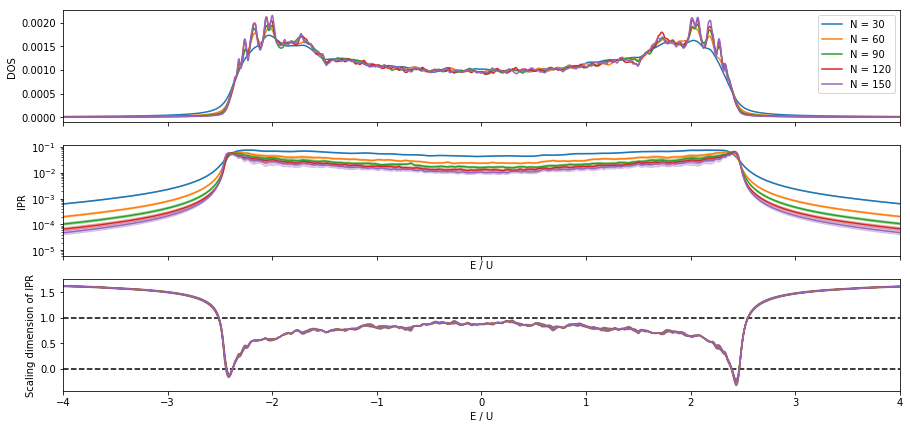

In [6]:
def plot_scaling_dimension(o, T_i, spread_IPR = True):
    print(" ".join(f'{k}={v}' for k,v in o.parameters.items() if k != 'J_matrix'))
    try:
        m, c, dm, dc = scaling_dimension(o.Ns, o.IPR[:, T_i], o.dIPR[:, T_i], use_true_errors = True)
        scaling_fit = True
    except:
        scaling_fit = False

    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    f, axes = plt.subplots(3,1, figsize = (15,7), sharex = 'col')

    for i,N in zip(count(), o.Ns):
        axes[0].plot(o.energy_histogram_bins[1:] / o.parameters.U, o.DOS[i, T_i], label = f'N = {N}', color = colors[i])
        if spread_IPR:
            spread(axes[1], o.energy_histogram_bins[1:] / o.parameters.U, o.IPR[i, T_i], o.dIPR[i, T_i], color = colors[i])
        else:    
            axes[1].plot(o.energy_histogram_bins[1:] / o.parameters.U, o.IPR[i, T_i], color = colors[i])

        if scaling_fit: spread(axes[2], o.energy_histogram_bins[1:] / o.parameters.U, -m, dm, color = colors[i])


    axes[2].set(ylabel = 'Scaling dimension of IPR', xlim = (-1,1), xlabel = 'E / U')

    axes[0].set(ylabel = 'DOS')    
    axes[1].set(ylabel = 'IPR', xlim = (-4,4), xlabel = 'E / U', yscale = 'log')

    xlim = axes[2].get_xlim()
    axes[2].hlines([0,1], xmin = xlim[0], xmax = xlim[1], linestyles = 'dashed')

    axes[0].legend();
    
    
T_i = 0
T = oHighT.Ts[T_i]
print(f'T = {T}, T_i = {T_i}')
plot_scaling_dimension(oHighT, T_i)

T = inf, T_i = 0
mu=0.0 beta=nan U=1 t=1 N=150 alpha=1.25 J=5


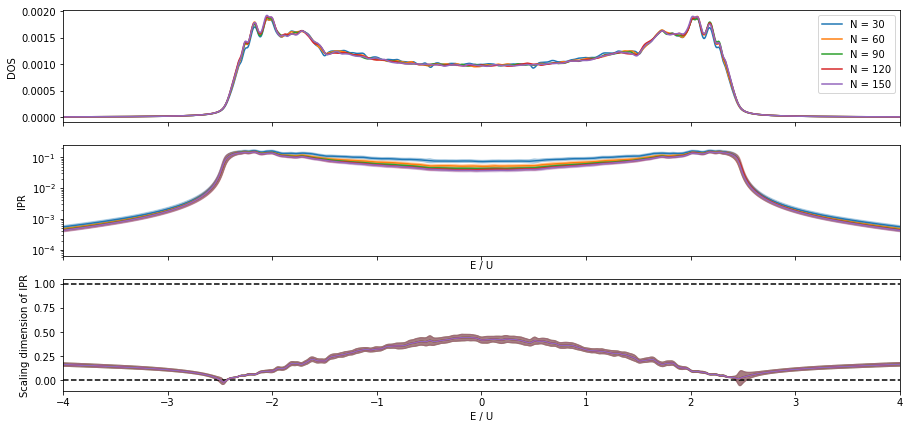

In [7]:
T_i = 0
T = oinfT.Ts[T_i]
print(f'T = {T}, T_i = {T_i}')
plot_scaling_dimension(oinfT, T_i)

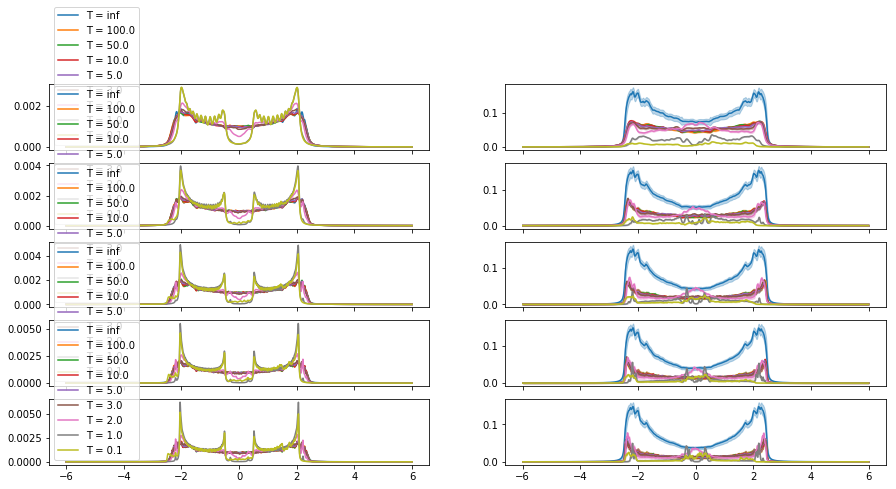

In [9]:
def compare_DOS_IPR(os, T_is, spread_IPR = True):
    Ns = os[0].Ns
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    f, axes = plt.subplots(len(Ns),2, figsize = (15,7), sharex = 'col')

    for i,N in zip(count(), Ns):
        for j,o,T_i in zip(count(),os, T_is):
            axes[i, 0].plot(o.energy_histogram_bins[1:] / o.parameters.U, o.DOS[i, T_i], label = f'T = {o.Ts[T_i]}', color = colors[j])
        
            if spread_IPR:
                spread(axes[i, 1], o.energy_histogram_bins[1:] / o.parameters.U, o.IPR[i, T_i], o.dIPR[i, T_i], color = colors[j])
            else:    
                axes[i, 1].plot(o.energy_histogram_bins[1:] / o.parameters.U, o.IPR[i, T_i], color = colors[j])

        
        axes[i, 0].legend()
        
        #if spread_IPR:
        #    spread(axes[1], o.energy_histogram_bins[1:] / o.parameters.U, o.IPR[i, T_i], o.dIPR[i, T_i], color = colors[i])
        #else:    
        #    axes[1].plot(o.energy_histogram_bins[1:] / o.parameters.U, o.IPR[i, T_i], color = colors[i])

        #spread(axes[2], o.energy_histogram_bins[1:] / o.parameters.U, -m, dm, color = colors[i])


    #axes[2].set(ylabel = 'Scaling dimension of IPR', xlim = (-1,1), xlabel = 'E / U')

    #axes[0].set(ylabel = 'DOS')    
    #axes[1].set(ylabel = 'IPR', xlim = (-4,4), xlabel = 'E / U')

    #xlim = axes[2].get_xlim()
    #axes[2].hlines([0,1], xmin = xlim[0], xmax = xlim[1], linestyles = 'dashed')

    #axes[0].legend();
    
from itertools import chain, repeat    
T_is = [0,0,1,2,3,4,5,6,7]
#data_sources =  chain([oinfT,], repeat(oHighT))[:len(T_is)]
data_sources = [oinfT,oHighT,oHighT,oHighT,oHighT,oHighT,oHighT,oHighT,oHighT,oHighT,oHighT,oHighT,oHighT,]
              
compare_DOS_IPR(os = data_sources, 
                T_is = T_is,
                spread_IPR = True)

In [14]:
print(f'Computing the infT limit for Ns = {oHighT.Ns}')
oinfT = Munch()
o = oinfT
o.N_eigenstates = int(1e5) # do states / N disorder realisations
o.Ns = oHighT.Ns# system sizes
o.Ts = np.array([np.infty,])

o.t = 1
o.U = 10
o.J = 5
o.spread_IPR = False

o.energy_histogram_bins = oHighT.E_bins
shape = (4, len(o.Ns), 1, len(o.energy_histogram_bins)-1)
o.DOS, o.IPR, o.dDOS, o.dIPR = np.nan * np.zeros(shape = shape)

for i,N in zip(count(), o.Ns):
    M = o.N_eigenstates // N + 1 # Number of Disorder_realisations
    states = np.random.choice([1,0], size = (M,N)) #take 50-50 uncorrelated coin flips to simulate infinite temp limit.
    o.parameters = Munch(mu=0.0, beta = np.nan, U = o.U, t = o.t, N = N, alpha = 1.25, J = o.J)
    o.DOS[i], o.IPR[i], o.dDOS[i], o.dIPR[i] = solve(states, o.parameters, scale = 0.5, energy_histogram_bins = o.energy_histogram_bins)
    
o.hints = Munch()
for name in ['DOS', 'IPR', 'dIPR', 'dDOS']: o.hints[name] = ('Ns', 'Ts', 'energy')

Computing the infT limit for Ns = [ 30  60  90 120 150]


T = inf, T_i = 0
mu=0.0 beta=nan U=10 t=1 N=150 alpha=1.25 J=5


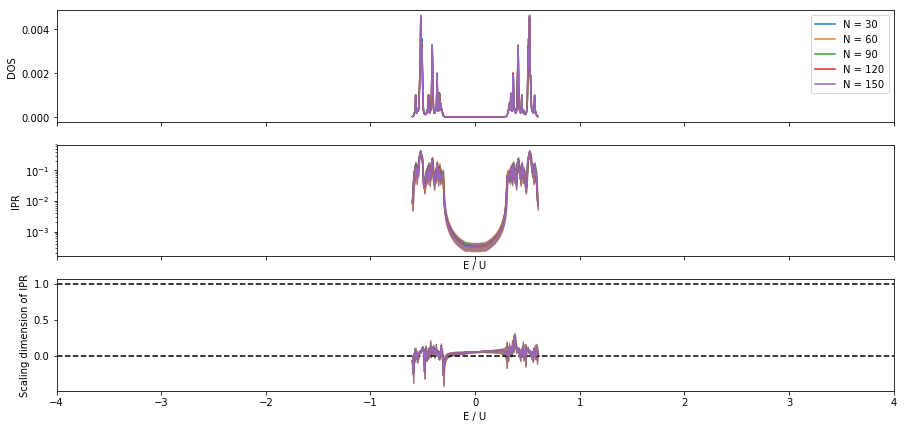

In [15]:
T_i = 0
T = oinfT.Ts[T_i]
print(f'T = {T}, T_i = {T_i}')
plot_scaling_dimension(oinfT, T_i)